*Literature*

- Screening solutions Horndeski: flat background https://arxiv.org/pdf/1302.2311.pdf

- Screening solutions Horndeski: cosmo background https://arxiv.org/pdf/1111.6749.pdf

In [1]:
#IMPORT
import numpy as np
#import mpmath as mp #problem with mp!
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import cumtrapz
from scipy.integrate import trapz
#from scipy.integrate import romberg
from scipy.interpolate import interp1d
from scipy import optimize

import astropy.units as astrou
#from astropy.cosmology import Planck18_arXiv_v2 as cosmo #not working on notebook
from astropy.cosmology import z_at_value

import sys
dir_base=sys.path[0]
dir_out=dir_base+"/gw_speed_spatial/"

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if int(base)==1:
            return r"10^{{{0}}}".format(int(exponent))
        if int(base)==-1:
            return r"-10^{{{0}}}".format(int(exponent))
        else:
            return r"{0} \cdot 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
print('latex test: '+latex_float(1.0e9), latex_float(-1e-9))

latex test: 10^{9} -10^{-9}


# Model-generic results

In [2]:
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform

# Time, orientation and location of the source in the sky
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0 #np.pi/2
time = 1000000000

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))

# These factors allow us to project a signal into what the detector would
# observe

## Generate a waveform
hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=30, mass2=30,
                         f_lower=30, delta_t=1.0/4096, inclination=inc,
                         distance=400)


fp=-0.3854854737104103, fc=0.7059872059706817


Text(0, 0.5, 'Strain')

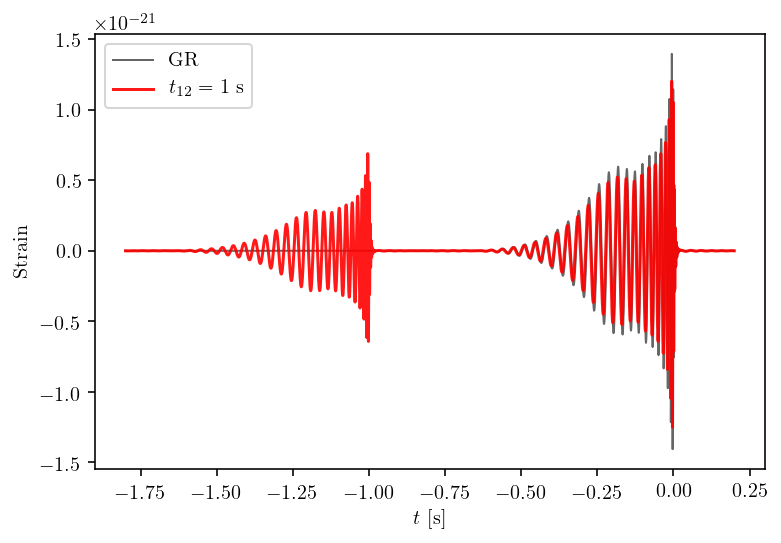

In [3]:

#apply the exponential in Fourier space
dt = 1
thp = hp.to_frequencyseries()
thp*= np.exp(2j*np.pi*thp.sample_frequencies*(dt))
hps = thp.to_timeseries()

#total response to the shifted signal
hts = fp * hps + fc * hc

#total response to the original signal
ht = fp * hp + fc * hc



plt.plot(ht.sample_times,ht,'k-',lw=1,alpha=0.6,label='GR')
plt.plot(hts.sample_times,hts,'r-',lw=1.5,alpha=0.9,label=r'$t_{12}=%g$ s'%dt)

plt.legend()
plt.xlabel(r'$t$ [s]')
plt.ylabel('Strain')

#plt.xlim(-0.65,0.2)

Text(0, 0.5, 'Amplitude')

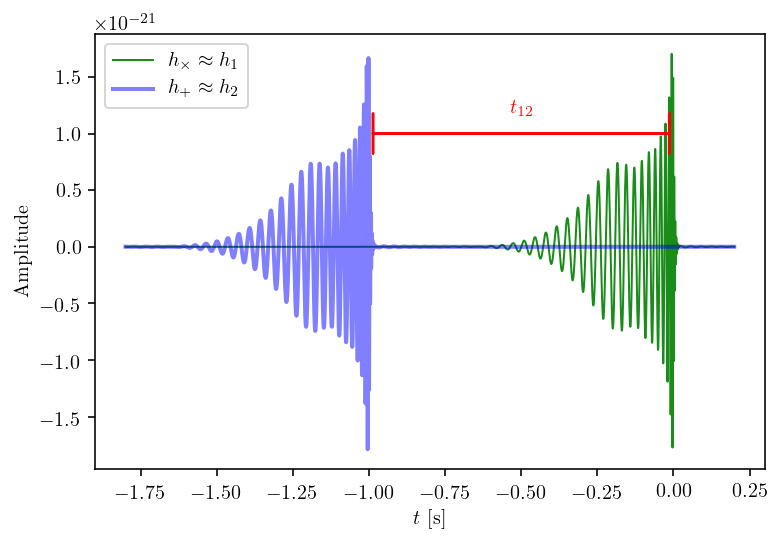

In [4]:
#fig, plt = plt.subplots(1,1, figsize=(5,5))


plt.plot(hc.sample_times,hc,'g-',lw=1,alpha=0.9,label=r'$h_\times\approx h_1$')
plt.plot(hps.sample_times,hps,'b-',lw=2,alpha=0.5,label=r'$h_+\approx h_2$')

plt.annotate('', xy=(0, 1e-21), xytext=(-dt, 1e-21), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|','color':'r','lw':1.5})
plt.annotate(r'$t_{12}$',c='r', xy=(-dt/2., 1.2e-21), ha='center', va='center')

plt.legend()
plt.xlabel(r'$t$ [s]')
plt.ylabel('Amplitude')

#plt.xlim(-0.65,0.2)

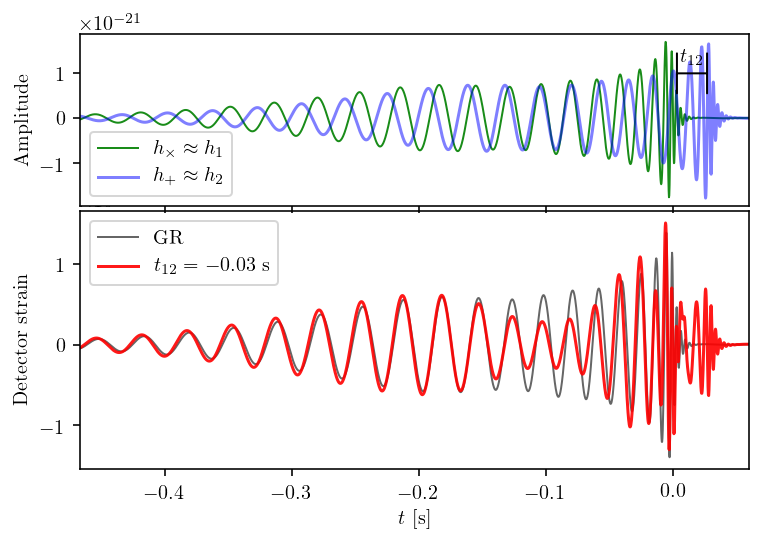

In [5]:
#combine the two plots

fig, ax = plt.subplots(2,1,sharex=True,
                       gridspec_kw={'height_ratios':[1,1.5]#,'width_ratios':[0.25,0.75]
                                   })
plt.subplots_adjust(hspace=0.025)

#apply the exponential in Fourier space
dt = -0.03
thp = hp.to_frequencyseries()
thp*= np.exp(2j*np.pi*thp.sample_frequencies*(dt))
hps = thp.to_timeseries()

#total response to the shifted signal
hts = fp * hps + fc * hc

#total response to the original signal
ht = fp * hp + fc * hc

ax[0].plot(hc.sample_times,hc,'g-',lw=1,alpha=0.9,label=r'$h_\times\approx h_1$')
ax[0].plot(hps.sample_times,hps,'b-',lw=1.5,alpha=0.5,label=r'$h_+\approx h_2$')

ax[0].annotate('', xy=(0, 1e-21), xytext=(-dt, 1e-21), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|','color':'k','lw':1.})
ax[0].annotate(r'$t_{12}$',c='k', xy=(-dt/2., 1.3e-21), ha='center', va='center')

ax[0].legend(loc='lower left')
#ax[0].set_xlabel(r'$t$ [s]')
ax[0].set_ylabel('Amplitude')

ax[1].plot(ht.sample_times,ht,'k-',lw=1,alpha=0.6,label='GR')
ax[1].plot(hts.sample_times,hts,'r-',lw=1.5,alpha=0.9,label=r'$t_{12}=%g$ s'%dt)

#ax[1].set_autoscaley_on(False)
ax[1].legend(loc='upper left')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].set_ylabel('Detector strain')

ax[1].set_xlim(-0.5-(1.1*dt),max(0.05,-2*dt))
ax[0].set_zorder(1)
ax[1].set_zorder(0)




In [6]:
#systematic plotting
#based on https://pycbc.org/pycbc/latest/html/detector.html#antenna-patterns-and-projecting-a-signal-into-the-detector-frame

from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform
import numpy as np
import matplotlib.pyplot as plt

print_plots = True

dt_list = [0.7,0.05,-0.05,0.005,-0.005]

# Time, orientation and location of the source in the sky
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0 #np.pi/2
time = 1000000000

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))

# These factors allow us to project a signal into what the detector would
# observe

## Generate a waveform
hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=30, mass2=30,
                         f_lower=30, delta_t=1.0/4096, inclination=inc,
                         distance=400)


#apply the exponential in Fourier space
for dt in dt_list:
    fig, ax = plt.subplots(2,1,sharex=True,
                       gridspec_kw={'height_ratios':[1,1.5]#,'width_ratios':[0.25,0.75]
                                   })
    plt.subplots_adjust(hspace=0.025)
    thp = hp.to_frequencyseries()
    thp*= np.exp(2j*np.pi*thp.sample_frequencies*(dt))
    hps = thp.to_timeseries()

    #total response to the shifted signal
    hts = fp * hps + fc * hc

    #total response to the original signal
    ht = fp * hp + fc * hc

    ax[0].plot(hc.sample_times,hc,'g-',lw=1,alpha=0.9,label=r'$h_\times\approx h_1$')
    ax[0].plot(hps.sample_times,hps,'b-',lw=1.5,alpha=0.5,label=r'$h_+\approx h_2$')

    ax[0].annotate('', xy=(0, 1e-21), xytext=(-dt, 1e-21), xycoords='data', textcoords='data',
                arrowprops={'arrowstyle': '|-|','color':'k','lw':1.})
    ax[0].annotate(r'$t_{12}$',c='k', xy=(-dt/2., 1.3e-21), ha='center', va='center')

    ax[0].legend(loc='lower left')
    #ax[0].set_xlabel(r'$t$ [s]')
    ax[0].set_ylabel('Amplitude')

    ax[1].plot(ht.sample_times,ht,'k-',lw=1,alpha=0.6,label='GR')
    ax[1].plot(hts.sample_times,hts,'r-',lw=1.5,alpha=0.9,label=r'$t_{12}=%g$ s'%dt)

    #ax[1].set_autoscaley_on(False)
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r'$t$ [s]')
    ax[1].set_ylabel('Detector strain')

    ax[1].set_xlim(-0.5-(1.1*dt),max(0.05,-2*dt))
    ax[0].set_zorder(1)
    ax[1].set_zorder(0)

    if print_plots:
        plt.savefig('gw_speed_spatial/GW_signal_delay_t12='+str(dt).replace('.','')+'.pdf',bbox_inches='tight')
        plt.savefig('gw_speed_spatial/GW_signal_delay_t12='+str(dt).replace('.','')+'.png')
        
    plt.close()
    hts.save_to_wav('gw_speed_spatial/GW_signal_delay_t12='+str(dt).replace('.','')+'.wav')


fp=-0.3854854737104103, fc=0.7059872059706817


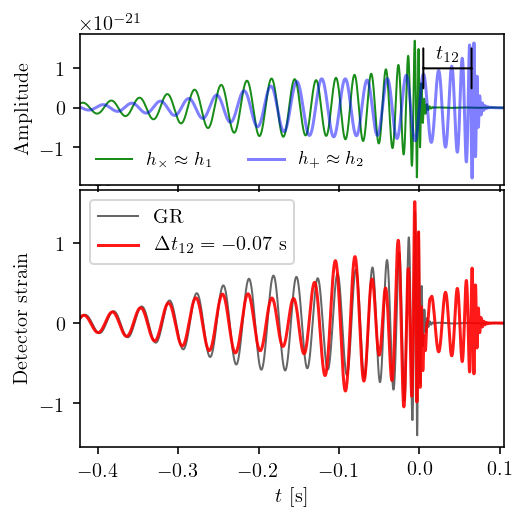

In [7]:
#combine the two plots

fig, ax = plt.subplots(2,1,sharex=True,
                       gridspec_kw={'height_ratios':[1,1.7]#,'width_ratios':[0.25,0.75]
                                   })
plt.subplots_adjust(hspace=0.025)

#apply the exponential in Fourier space
dt = -0.07
thp = hp.to_frequencyseries()
thp*= np.exp(2j*np.pi*thp.sample_frequencies*(dt))
hps = thp.to_timeseries()

#total response to the shifted signal
hts = fp * hps + fc * hc

#total response to the original signal
ht = fp * hp + fc * hc

ax[0].plot(hc.sample_times,hc,'g-',lw=1,alpha=0.9,label=r'$h_\times\approx h_1$')
ax[0].plot(hps.sample_times,hps,'b-',lw=1.5,alpha=0.5,label=r'$h_+\approx h_2$')

ax[0].annotate('', xy=(0, 1e-21), xytext=(-dt, 1e-21), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|','color':'k','lw':1.})
ax[0].annotate(r'$t_{12}$',c='k', xy=(-dt/2., 1.3e-21), ha='center', va='center')

ax[0].legend(loc='lower left',ncol=2,fontsize=9,frameon=False)
#ax[0].set_xlabel(r'$t$ [s]')
ax[0].set_ylabel('Amplitude')

ax[1].plot(ht.sample_times,ht,'k-',lw=1,alpha=0.6,label='GR')
ax[1].plot(hts.sample_times,hts,'r-',lw=1.5,alpha=0.9,label=r'$\Delta t_{12}=%g$ s'%dt)

#ax[1].set_autoscaley_on(False)
ax[1].legend(loc='upper left')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].set_ylabel('Detector strain')

ax[1].set_xlim(-0.5-(1.1*dt),max(0.05,-1.5*dt))
ax[0].set_zorder(1)
ax[1].set_zorder(0)

plt.gcf().set_size_inches(3.8,3.8)

#plt.title('GW scrambling')
if False:
    plt.savefig('gw_speed_spatial/GW_signal_delay_editors.pdf',bbox_inches='tight')
    plt.savefig('gw_speed_spatial/GW_signal_delay_editors.png',dpi=300)
    plt.savefig('gw_speed_spatial/GW_signal_delay_editors.jpg',dpi=300)


## Include the orientation angle

With the definitions in figure 2 of Ezquiaga & Zuma '20, neglecting the scalar field and using eq (63) therein for $L=1$ (single lensing event) and assuming negligible effects at order $\epsilon^{-1}$, one gets the following matrix relating the detected and the source amplitude
$$ \vec h_d \approx e^{i\omega t_1}\hat{\mathcal M}\text{diag}(1,\Delta)\hat{\mathcal M}^{-1}$$
where $\Delta=e^{-i\omega \Delta t_{12}}$ and components are arranged as $h = (h_{+},h_{\times})^T$. Here the mixing matrix reads
$$\hat{\mathcal M} = \left(
\begin{array}{cc}
-\sin(2\phi) & \cos(2\phi) \\
\cos(2\phi) & \sin(2\phi)
\end{array}\right) $$
($\phi$ is the angle between the lens and the source, relative to the $\hat x$ direction defining the polarizations).

The result is 
$$\left(
\begin{array}{cc}
 \frac{1}{2} ((\Delta -1) \cos (4 \phi )+\Delta +1) & \frac{1}{2} (\Delta -1) \sin (4 \phi ) \\
 \frac{1}{2} (\Delta -1) \sin (4 \phi ) & \frac{1}{2} (-(\Delta -1) \cos (4 \phi )+\Delta +1) \\
\end{array}
\right)$$

(-0.7, 0.2)

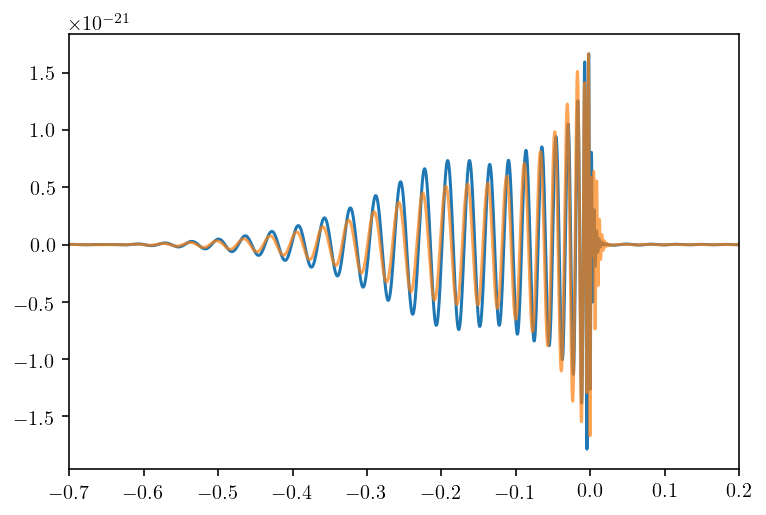

In [96]:
from numpy.linalg import inv #, matmul

dt12 = -0.01 #time delay in seconds
phi = np.pi/5. #lens missalignment param

#frequency components
thp = hp.to_frequencyseries()
thc = hc.to_frequencyseries()

mix_mat = np.array([[-np.sin(2*phi),np.cos(2*phi)],[np.cos(2*phi),np.sin(2*phi)]])
inv_mix = inv(mix_mat)

#phase coefficient for the time delay
Delta = np.exp(2j*np.pi*(dt12)*thp.sample_frequencies)
#print(Delta)

#use the closed form for simplicity instead of the mixing matrices

#shift and add the other component 
#NOTE: just combining the components doesn't allow "to_timeseries" afterwards
#note: to add the other component we add the 
thp *= 1/2.*((Delta-1.)*np.cos(4*phi)+Delta+1)
thp += 1/2.*(Delta-1.)*np.sin(4.*phi)*hc.to_frequencyseries()
thc *= 1/2.*(-(Delta-1.)*np.cos(4*phi)+Delta+1)
thc += 1/2.*(Delta-1.)*np.sin(4.*phi)*hp.to_frequencyseries()

hp_len = thp.to_timeseries()
hc_len = thc.to_timeseries()

#thp_len =  1/2.*((Delta-1.)*np.cos(4*phi)+Delta+1)*thp + 1/2.*(Delta-1.)*np.sin(4.*phi)*thc
#thc_len = 1/2.*(Delta-1.)*np.sin(4.*phi)*thp + 1/2.*(-(Delta-1.)*np.cos(4*phi)+Delta+1)*thc

plt.plot(hp.sample_times, hp)
plt.plot(hp_len.sample_times, hp_len,alpha=0.7)
plt.xlim(-.7,0.2)
#frequencies are the same
#plt.plot(thp.sample_frequencies/thc.sample_frequencies

#plt.loglog(thp.sample_frequencies,np.abs(thp))
#plt.loglog(thp.sample_frequencies,np.abs(thc))

#plt.plot(hp.sample_times,hp)
#plt.loglog(thp.sample_frequencies,np.abs(thp) )
#plt.xlim(0,1000)

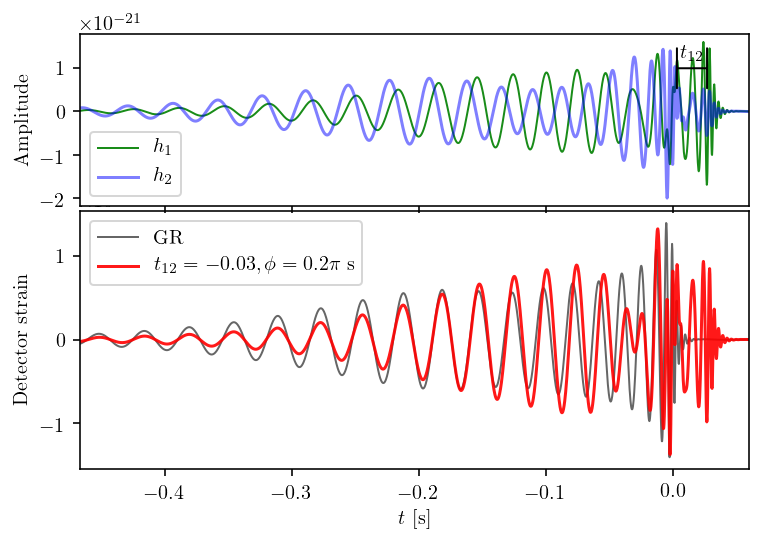

In [103]:
#combine the two plots

fig, ax = plt.subplots(2,1,sharex=True,
                       gridspec_kw={'height_ratios':[1,1.5]#,'width_ratios':[0.25,0.75]
                                   })
plt.subplots_adjust(hspace=0.025)

dt12 = -0.03 #time delay in seconds
phi = np.pi/5. #lens missalignment param

#frequency components
thp = hp.to_frequencyseries()
thc = hc.to_frequencyseries()

#phase coefficient for the time delay
Delta = np.exp(2j*np.pi*(dt12)*thp.sample_frequencies)

#use the closed form for simplicity instead of the mixing matrices

#shift and add the other component 
#NOTE: just combining the components doesn't allow "to_timeseries" afterwards
#note: to add the other component we add the 
thp *= 1/2.*((Delta-1.)*np.cos(4*phi)+Delta+1)
thp += 1/2.*(Delta-1.)*np.sin(4.*phi)*hc.to_frequencyseries()
thc *= 1/2.*(-(Delta-1.)*np.cos(4*phi)+Delta+1)
thc += 1/2.*(Delta-1.)*np.sin(4.*phi)*hp.to_frequencyseries()

hp_len = thp.to_timeseries()
hc_len = thc.to_timeseries()

#total response to the shifted signal
hts = fp * hp_len + fc * hc_len

#total response to the original signal
ht = fp * hp + fc * hc

ax[0].plot(hc.sample_times,hc_len,'g-',lw=1,alpha=0.9,label=r'$h_1$')
ax[0].plot(hps.sample_times,hp_len,'b-',lw=1.5,alpha=0.5,label=r'$h_2$')

ax[0].annotate('', xy=(0, 1e-21), xytext=(-dt, 1e-21), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|','color':'k','lw':1.})
ax[0].annotate(r'$t_{12}$',c='k', xy=(-dt/2., 1.3e-21), ha='center', va='center')

ax[0].legend(loc='lower left')
#ax[0].set_xlabel(r'$t$ [s]')
ax[0].set_ylabel('Amplitude')

ax[1].plot(ht.sample_times,ht,'k-',lw=1,alpha=0.6,label='GR')
ax[1].plot(hts.sample_times,hts,'r-',lw=1.5,alpha=0.9,label=r'$t_{12}=%g, \phi=%g\pi$ s'%(dt,phi/np.pi))

#ax[1].set_autoscaley_on(False)
ax[1].legend(loc='upper left')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].set_ylabel('Detector strain')

ax[1].set_xlim(-0.5-(1.1*dt),max(0.05,-2*dt))
ax[0].set_zorder(1)
ax[1].set_zorder(0)

## Plot for the diagram

In [ ]:
## Generate a waveform
hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=30, mass2=30,
                         f_lower=30, delta_t=1.0/4096, inclination=inc,
                         distance=400)

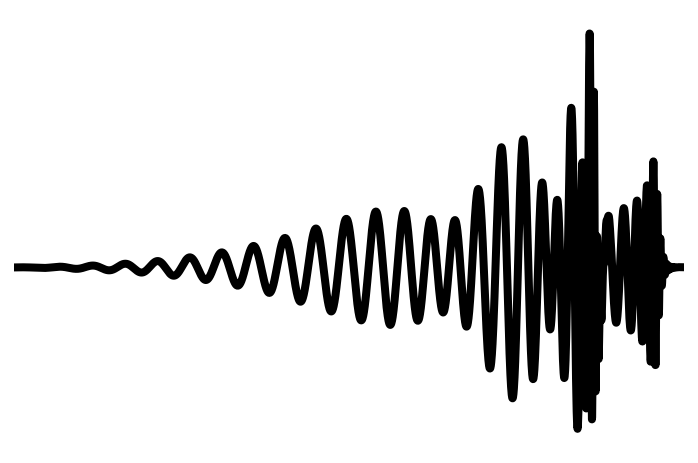

In [21]:

#apply the exponential in Fourier space
dt = -0.07
thp = hp.to_frequencyseries()
thp*= np.exp(2j*np.pi*thp.sample_frequencies*(dt))
hps = thp.to_timeseries()

#total response to the shifted signal
hts = fp * hps + fc * hc

#total response to the original signal
ht = fp * hp + fc * hc

fig, ax = plt.subplots()

#ax.plot(ht.sample_times,ht,'k-',lw=1,alpha=0.6,label='GR')
ax.plot(hts.sample_times,hts,'k-',lw=4,alpha=1)#label=r'$t_{12}=%g$ s'%dt)

fig.patch.set_visible(False)
ax.axis('off')

#ax.legend()
#ax.xlabel(r'$t$ [s]')
#ax.ylabel('Strain')

ax.set_xlim(-0.65,0.1)
plt.savefig('gw_birefringence/paper_plots/gw_scrambled_plot.pdf')

# Animation

trying http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/
better https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image

In [6]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

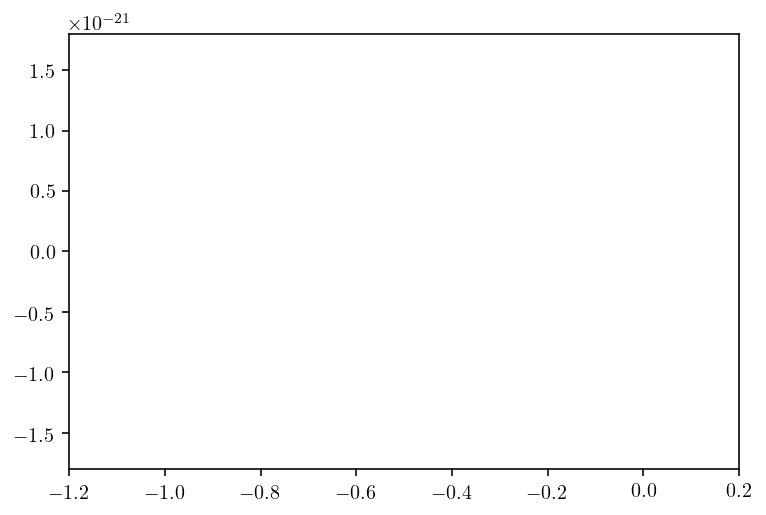

In [135]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

T0 = 0.1
DT = 0.7 #total time
n = 100 #number of intervals

#set_xlim(-0.5-(1.1*dt),max(0.05,-2*dt))
#ax.set_xlim(( -1.2, 0.05))
ax.set_xlim((-0.5-(1.*DT),max(0.05,+2*T0)))
ax.set_ylim((-1.8e-21, 1.8e-21))

line, = ax.plot([], [],'k-', lw=1)

In [136]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [137]:
# animation function. This is called sequentially
def animate(i):
    
    thp = hp.to_frequencyseries()
    thp*= np.exp(2j*np.pi*thp.sample_frequencies*(DT*(n-i)/n-T0))
    hps = thp.to_timeseries()
    
    hts = fp * hps + fc * hc
    
    x = hts.sample_times #np.linspace(0, 2, 1000)
    y = hts #np.sin(2 * np.pi * (x - 0.01 * i))
    
    line.set_data(hts.sample_times, hts)
    #print(i,)
    #x = np.linspace(0, 2, 1000)
    #y = np.sin(2 * np.pi * (x - 0.01 * i))
    #print(x,y)
    #line.set_data(x, y)
    return (line,)

In [138]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n, interval=40, blit=True)

In [139]:
anim

In [140]:
anim.save('gw_birefringence/scrambled_GW.gif', writer='imagemagick', fps=100/4)

In [141]:
#Image(url='gw_birefringence/scrambled_GW.gif')